In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.datasets import mnist


#loading and processing the data

In [4]:
(x_train , y_train) , (x_test , y_test) = mnist.load_data()

x_train = x_train/255.
x_test = x_test/255.

x_train = np.reshape(x_train , (60000 , 784))
x_test = np.reshape(x_test , (10000 , 784))

#adding noise to the images

In [5]:
x_train_noise = x_train + np.random.rand(60000 , 784)*0.9
x_test_noise = x_test + np.random.rand(10000 , 784)*0.9

x_train_noise = np.clip(x_train_noise , 0. , 1.)
x_test_noise = np.clip(x_test_noise , 0. , 1.)


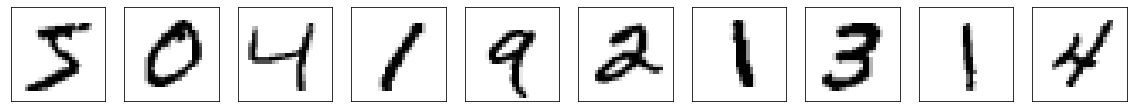

In [16]:
def plot(x , pred , labels = False):
  plt.figure(figsize=(20 , 2))
  for i in range(10):
    plt.subplot(1 , 10 , i+1)
    plt.imshow(x[i].reshape(28 , 28) , cmap='binary')
    plt.xticks([])
    plt.yticks([])
    if labels:
      plt.xlabel(np.argmax(pred[i]))
  plt.show()


plot(x_train , None)

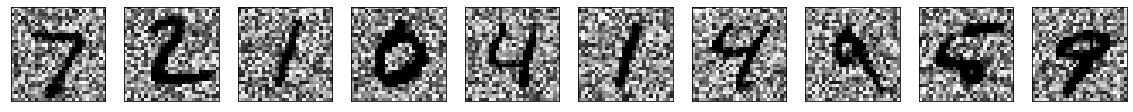

In [17]:
plot(x_test_noise , None)

#building and training the classifier

In [19]:
classifier_model = tf.keras.models.Sequential([
                                                       tf.keras.layers.Dense(256 , 
                                                                             activation = 'relu',
                                                                             input_shape = (784,)),
                                                       tf.keras.layers.Dense(256 , activation='relu'),
                                                       tf.keras.layers.Dense(10 , activation = 'softmax')
])

classifier_model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics=['accuracy'])

classifier_model.fit(x_train , y_train , batch_size = 512 , epochs = 3)

Epoch 1/3
118/118 [==============================] - 2s 18ms/step - loss: 0.7931 - accuracy: 0.7854
Epoch 2/3
118/118 [==============================] - 2s 18ms/step - loss: 0.1715 - accuracy: 0.9498
Epoch 3/3
118/118 [==============================] - 2s 17ms/step - loss: 0.1062 - accuracy: 0.9695


In [20]:
# evaluating on test set

loss , acc = classifier_model.evaluate(x_test , y_test)
print(acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.0974 - accuracy: 0.9688
0.9688000082969666


In [21]:
# evaluating on noisy test data 

loss , acc = classifier_model.evaluate(x_test_noise , y_test)
print(acc)

313/313 [==============================] - 1s 2ms/step - loss: 7.3655 - accuracy: 0.1871
0.18709999322891235


we can see that the accuracy on noisy data is bad

#building the autoencoder

In [23]:
input_img = tf.keras.layers.Input(shape = (784,))
encoder = tf.keras.layers.Dense(64 , activation = 'relu')(input_img)
decoder = tf.keras.layers.Dense(784 , activation='sigmoid')(encoder)

Autoencoder = tf.keras.Model(input_img , decoder)
Autoencoder.compile(optimizer = 'adam' , loss = 'binary_crossentropy')

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

Autoencoder.fit(x_train_noise , x_train , 
                epochs = 100 ,
                batch_size=512 ,
                validation_split=0.2 , verbose = 1,
                callbacks = [EarlyStopping(monitor = 'val_loss' , patience = 5)])


Epoch 1/100
94/94 [==============================] - 3s 27ms/step - loss: 0.4049 - val_loss: 0.2565
Epoch 2/100
94/94 [==============================] - 2s 22ms/step - loss: 0.2485 - val_loss: 0.2233
Epoch 3/100
94/94 [==============================] - 2s 23ms/step - loss: 0.2163 - val_loss: 0.1958
Epoch 4/100
94/94 [==============================] - 2s 23ms/step - loss: 0.1914 - val_loss: 0.1805
Epoch 5/100
94/94 [==============================] - 2s 23ms/step - loss: 0.1771 - val_loss: 0.1687
Epoch 6/100
94/94 [==============================] - 2s 22ms/step - loss: 0.1656 - val_loss: 0.1589
Epoch 7/100
94/94 [==============================] - 2s 22ms/step - loss: 0.1559 - val_loss: 0.1506
Epoch 8/100
94/94 [==============================] - 2s 22ms/step - loss: 0.1481 - val_loss: 0.1438
Epoch 9/100
94/94 [==============================] - 2s 22ms/step - loss: 0.1414 - val_loss: 0.1383
Epoch 10/100
94/94 [==============================] - 2s 22ms/step - loss: 0.1363 - val_loss: 0.1339

#prediction

In [25]:
predictions = Autoencoder.predict(x_test_noise)

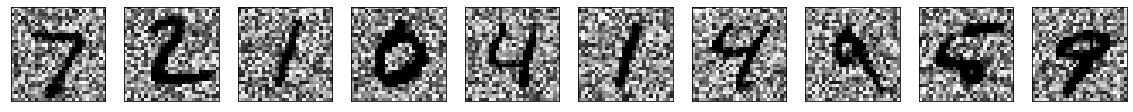

In [26]:
plot(x_test_noise , None)

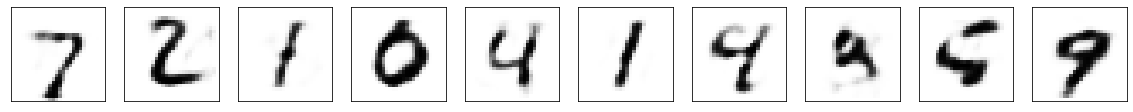

In [28]:
plot(predictions , None)

#now we want to test predicted image with our first model 

In [30]:
loss , accuracy = classifier_model.evaluate(predictions , y_test)
print(accuracy)

313/313 [==============================] - 1s 2ms/step - loss: 0.1552 - accuracy: 0.9510
0.9509999752044678


it is very good now

# now building the full model

In [31]:
Input_image = tf.keras.layers.Input(shape = (784,))
x = Autoencoder(Input_image)
y = classifier_model(x)

model = tf.keras.Model(Input_image , y)

In [32]:
preds = model.predict(x_test_noise)

# plotting the noisy images with the predictions

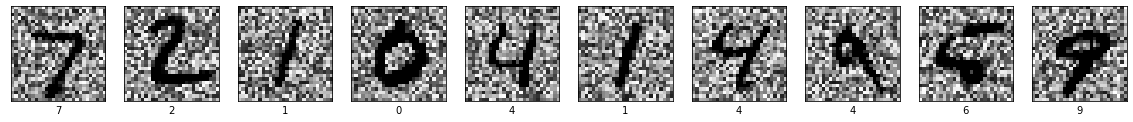

In [33]:
plot(x_test_noise , preds , True)

#plotting the noisy images with the actual valuse

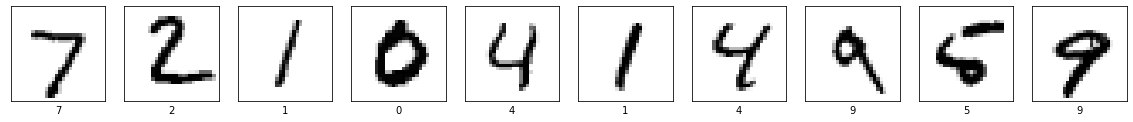

In [35]:
y_categ = tf.keras.utils.to_categorical(y_test)

plot(x_test , y_categ , True)